# Sinkhorn algorithm
## Regularized OT
We define the discrete entropy of a coupling matrix as :
$$\mathbf{H(P)} \overset{\text{def}}{=} - \sum_{i,j}P_{i,j} (\log P_{i,j} - 1)$$

We then modify the original optimal transport problem to define :
$$L_C^\varepsilon(a,b) \overset{\text{def}}{=} \min_{P \in U(a,b)} \left\langle P, C\right\rangle - \epsilon H(P)$$

We have that :
$$L_C^\varepsilon(a,b) \overset{\varepsilon \to 0}{\longrightarrow} L_C(a,b)$$

The advantage of this regularized $L_C^\varepsilon$ problem is that it as a solution of a specific form :

---
The solution $L_C^\varepsilon$ is unique and has the form :
$$P = \mathrm{diag}(u) K \mathrm{diag}(v)$$
With :
 - $K = \exp(-\frac{C}{\varepsilon})$
 - $u = \exp(\frac{f}{\varepsilon}), v = \exp(\frac{g}{\varepsilon})$, where $f$ and $g$ are the Kantorovich potentials.
---

A simple and efficient algorithm to find a solution to this problem is then to use matrix scaling. This algorithm is called Sinkhorn algorithm and iterates as follow :
    $$u^{(l+1)} = \frac{a}{Kv^{(l)}}, v^{(l+1)} = \frac{b}{Ku^{(l+1)}}$$


In [1]:
import matplotlib.pyplot as plt 
from sklearn.datasets import make_moons, make_circles
from scipy.spatial import distance_matrix
import numpy as np
import tensorflow as tf

from cvxopt import matrix, solvers
%matplotlib inline

Here, we define the same distributions as in the LP formulation.

In [2]:
n = 25
m = 25
moons, mclass = make_circles(max(n,m)*2, noise = 0.15, factor=0.6, random_state=42)
#moons, mclass = make_moons(max(n,m)*2, noise = 0.15)
np.random.seed(42)
axy = moons[mclass==0][:n]
a = np.random.rand(n, 1)
a = a/np.sum(a)

bxy = moons[mclass==1][:m]
b = np.random.rand(m, 1)
b = b/np.sum(b)

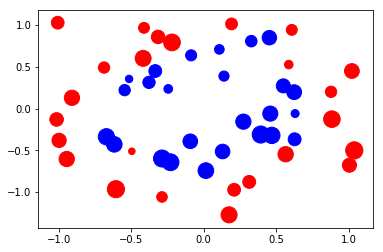

In [3]:
plt.scatter(axy[:,0], axy[:,1], s = a**(1/2)*1000, c="red")
plt.scatter(bxy[:,0], bxy[:,1], s = b**(1/2)*1000, c="blue")

In [4]:
C = distance_matrix(axy, bxy, p=2)**2

We choose a regularisation parameters $\epsilon$, close to 0.

In [5]:
eps = 0.01

In [6]:
K = np.exp(-C/eps)

We iterate until the solution converges to a good solution.

In [7]:
ou = np.zeros((n,))
ov = np.zeros((m,))
u = np.ones((n,))
v = np.ones((m,))
a = a.reshape(-1)
b = b.reshape(-1)
while np.sum((ou - u)**2) > 1e-5 or np.sum((ov - v)**2) > 1e-5:
    ou = u
    ov = v
    u = a/(K@v)
    v = b/(K.T@u)

We can find the plan $P$ using the formula as defined in the sinkhorn algorithm.

In [8]:
P = np.diag(u)@K@np.diag(v)

In [9]:
cost = np.sum(np.multiply(C,P))
print(f"Total cost : {cost}")

Total cost : 0.3389781836120558


We find a solution with a cost somewhat close the the solution found using LP. 

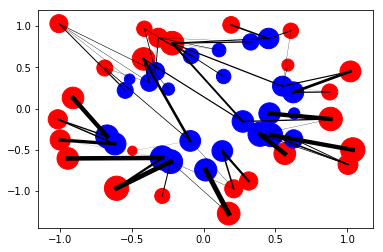

In [10]:
plt.scatter(axy[:,0], axy[:,1], s = a**(1/2)*2000, c="red")
plt.scatter(bxy[:,0], bxy[:,1], s = b**(1/2)*2000, c="blue")
maxP = np.max(P)
for i in range(n):
    for j in range(m):
        plt.plot([axy[i,0], bxy[j,0]], [axy[i,1], bxy[j,1]], linewidth=P[i,j]*5/maxP, linestyle="-", c="black")

# Sinkhorn in Log-Domain

We use Sinkhorn iterations in logdomain, which can be written, simply taking the log of the previous iterates, as :
    $$\log u^{(l+1)} = \log\frac{a}{Kv^{(l)}}, \log v^{(l+1)} = \log\frac{b}{Ku^{(l+1)}}$$
    $$\frac{f^{(l+1)}}{\varepsilon} = \log a - \log Kv^{(l)}, \frac{g^{(l+1)}}{\varepsilon} = \log b - \log Ku^{(l+1)}$$
    $$f^{(l+1)} = \varepsilon \log a - \varepsilon \log Kv^{(l)}, g^{(l+1)} = \varepsilon \log b - \varepsilon \log Ku^{(l+1)}$$
    
We define softmin as :
$$\min_\varepsilon \overset{\text{def}}{=} -\varepsilon \log \sum_i e^{-z_i/\varepsilon}$$

We can then rewrite the iterates as :
    $$f^{(l+1)}_i = \varepsilon \log a - \varepsilon \min_\varepsilon (C_i - g^{(l)}), g^{(l+1)}_i = \varepsilon \log b - \varepsilon \min_\varepsilon(C_i - f^{(l+1)})$$

In [64]:
eps = 1/500

Here, we use the TensorFlow implementation of *LogSumExp* (LSE) reduction.

This implementation uses the following trick :
Given a vector $x$, we write $\underline{x} = \max x$ and then write LSE as :
$$\log \sum_i e^{x_i} = \log \sum_i e^{x_i - \underline{x}}e^\underline{x} = \underline{x} + \log \sum_i e^{x_i - \underline{x}}$$

In [65]:
def shsoftmin(z, eps, axis=1):
    return -eps * tf.math.reduce_logsumexp(-z/eps, axis=axis)

In [78]:
of = tf.zeros((n,), dtype=tf.float64)
og = tf.zeros((m,), dtype=tf.float64)
f = tf.ones((n,), dtype=tf.float64)/n
g = tf.ones((m,), dtype=tf.float64)/m
a = a.reshape(-1)
b = b.reshape(-1)

while tf.math.reduce_max((of - f)**2) > 1e-15 or tf.math.reduce_max((og - g)**2) > 1e-15:
    of = f
    og = g
    f = eps*tf.math.log(a) + shsoftmin(C - tf.expand_dims(g, axis=0), eps, axis=1)
    g = eps*tf.math.log(b) + shsoftmin(C - tf.expand_dims(f, axis=1), eps, axis=0)

In [79]:
P = tf.linalg.diag(tf.exp(f/eps))@tf.exp(-C/eps)@tf.linalg.diag(tf.exp(g/eps))

In [80]:
P = P.numpy()

In [81]:
erra = np.max(np.sum(P, axis=1) - a)
errb = np.max(np.sum(P, axis=0) - b)
print(f"Marginals errors : a = {erra}, b = {errb}")

Marginals errors : a = 8.510369361655612e-07, b = 1.7555401576885288e-15


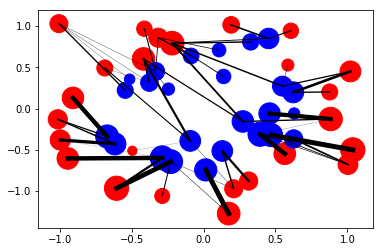

In [82]:
plt.scatter(axy[:,0], axy[:,1], s = a**(1/2)*2000, c="red")
plt.scatter(bxy[:,0], bxy[:,1], s = b**(1/2)*2000, c="blue")
maxP = np.max(P)
for i in range(n):
    for j in range(m):
        plt.plot([axy[i,0], bxy[j,0]], [axy[i,1], bxy[j,1]], linewidth=P[i,j]*5/maxP, linestyle="-", c="black")

In [83]:
cost = np.sum(np.multiply(C,P))
print(f"Total cost : {cost}")

Total cost : 0.3384302678394907


In [84]:
f - f[0]

<tf.Tensor: id=1400209, shape=(25,), dtype=float64, numpy=
array([ 0.        , -0.40612675, -0.09682492,  0.11612338, -0.01569643,
        0.62041177, -0.39089447,  0.40452261, -0.21012488,  0.31207676,
       -0.61054861, -0.18531634, -0.36689393,  0.04750865,  0.3510685 ,
       -0.35963982, -0.40599837, -0.20042494, -0.13059894,  1.13111931,
       -0.54945911, -0.4784181 , -0.35646123,  0.51326365, -0.0984898 ])>

In [85]:
g + f[0] - eps*np.log(b)

<tf.Tensor: id=1400216, shape=(25,), dtype=float64, numpy=
array([ 0.15754568, -0.10591257,  0.57134086,  0.55127887,  0.43558857,
        0.73729459, -0.4126689 , -0.14815825,  0.64023509,  0.63387011,
        0.54025367, -0.3478643 , -0.31266822,  0.40304558,  0.45350015,
       -0.1131543 ,  0.0460184 , -0.43521674,  0.65123646, -0.22832316,
        0.24448552,  0.36894664,  0.78036454,  0.4220888 , -0.26526743])>